In [23]:
library(terra)
library(tidyterra)
library(dplyr)
library(randomForest)

In [24]:
wa_shp <- vect("data/wa_shp_diss.gpkg")
wa_ecoreg <- vect("data/wa_l3_eco/wa_eco_l3.shp") |> project("EPSG:3740") |> tidyterra::select(US_L3NAME)

In [25]:
wa_ecoreg

 class       : SpatVector 
 geometry    : polygons 
 dimensions  : 9, 1  (geometries, attributes)
 extent      : 371124.2, 971138, 5043576, 5444546  (xmin, xmax, ymin, ymax)
 coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
 names       :        US_L3NAME
 type        :            <chr>
 values      :      Coast Range
               Columbia Plateau
                 Blue Mountains

In [26]:
ppt <- rast("data/stack_data/PRISM/wa_ppt.tif")
tmean <- rast("data/stack_data/PRISM/wa_tmean.tif")
vpd <- rast("data/stack_data/PRISM/wa_vpd.tif")

In [27]:
clim_stack <- c(ppt, tmean, vpd)

In [28]:
list_files <- list.files(path = "data/stack_data", full.names = TRUE, pattern = ".tif", include.dirs = FALSE)
list_files

[1] "data/stack_data/wa_dem_diss_prj3740.tif"
 [2] "data/stack_data/wa_dev27msk.tif"        
 [3] "data/stack_data/wa_dev3msk.tif"         
 [4] "data/stack_data/wa_dev81msk.tif"        
 [5] "data/stack_data/wa_dinfpoint.tif"       
 [6] "data/stack_data/wa_dinfsca.tif"         
 [7] "data/stack_data/wa_planc.tif"           
 [8] "data/stack_data/wa_profc.tif"           
 [9] "data/stack_data/wa_rugged.tif"          
[10] "data/stack_data/wa_slope.tif"           
[11] "data/stack_data/wa_twi.tif"

In [29]:
stack_data <- rast(list_files)
stack_data <- terra::subset(stack_data, "wa_dinfpoint", negate = TRUE)

In [30]:
wa_spec<- rast("data/Spectral/WA_median_mosaic.tif")
wa_spec <- terra::subset(wa_spec, "uncertainty", negate = TRUE)

In [31]:
wa_spec 

class       : SpatRaster 
dimensions  : 13366, 20286, 6  (nrow, ncol, nlyr)
resolution  : 30, 30  (x, y)
extent      : 362550, 971130, 5043570, 5444550  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
source      : WA_median_mosaic.tif 
names       : tree_~cover, NDVI_median, MNDWI_median, EVI_median, SAVI_median, NDYI_median 
min values  :           0,  -0.9962001,   -0.9924589,  -4.290172,  -0.3153680,   -2.461545 
max values  :          86,   0.9955124,    0.9966356,   7.263647,   0.8293253,    2.052344 

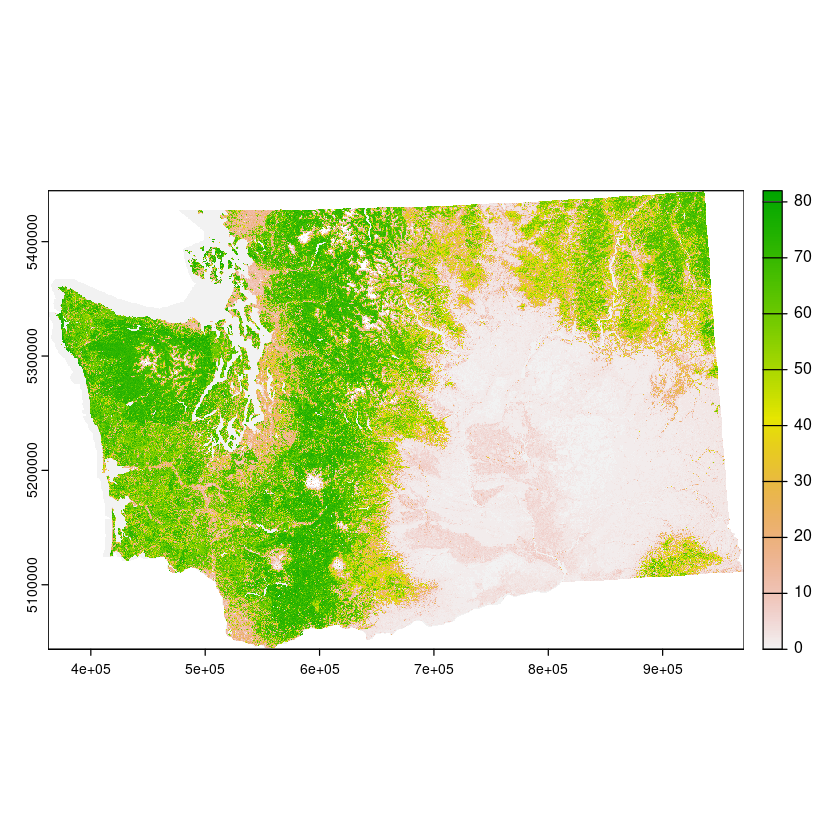

In [9]:
plot(wa_spec[[1]])

In [38]:
wa_pts <- vect("data/wa_all_pts.gpkg")
wa_pts

 class       : SpatVector 
 geometry    : points 
 dimensions  : 46607, 1  (geometries, attributes)
 extent      : 372213.1, 974284.3, 5040111, 5444105  (xmin, xmax, ymin, ymax)
 source      : wa_all_pts.gpkg
 coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
 names       : class
 type        : <chr>
 values      :   WET
                 WET
                 WET

In [39]:
wa_pts_ext <-  wa_pts |>
    terra::extract(x = stack_data, bind = T) |> 
    terra::extract(x = clim_stack, bind = T) |> 
    terra::extract(x = wa_spec, bind = T) |> 
    as.data.frame() |> 
    dplyr::mutate(class = as.factor(class)) |>
    na.exclude()

In [40]:
str(wa_pts_ext)

'data.frame':	43045 obs. of  20 variables:
 $ class                                     : Factor w/ 2 levels "UPL","WET": 2 2 2 2 2 2 2 2 2 2 ...
 $ NASADEM_HGT_n49w125                       : num  183.1 60.1 7.2 64.8 60.9 ...
 $ wa_dev27                                  : num  -0.4081 -0.7184 -0.3887 -1.2314 0.0167 ...
 $ wa_dev3                                   : num  0.0509 -0.56234 -0.00927 0.02517 0.08605 ...
 $ wa_dev81                                  : num  0.617 -0.898 -0.43 -0.862 -0.75 ...
 $ wa_dinfsca                                : num  64.7 433.2 23.6 23.6 51.2 ...
 $ wa_planc                                  : num  63.3 376.3 -71.6 96.5 -11 ...
 $ wa_profc                                  : num  -6.658 -0.951 2.883 -4.795 2.068 ...
 $ wa_rugged                                 : num  2.688 1.108 1.399 0.983 0.66 ...
 $ wa_slope                                  : num  6.98 2.02 3.8 2.76 1.61 ...
 $ wa_twi                                    : num  6.27 9.41 5.87 6.2 7.51

In [41]:
# Validation Set 
train.index <- as.vector(sample(c(1:nrow(wa_pts_ext)), 0.7*nrow(wa_pts_ext), replace=F))

train <- wa_pts_ext[train.index, ]

test <- wa_pts_ext[-train.index, ]

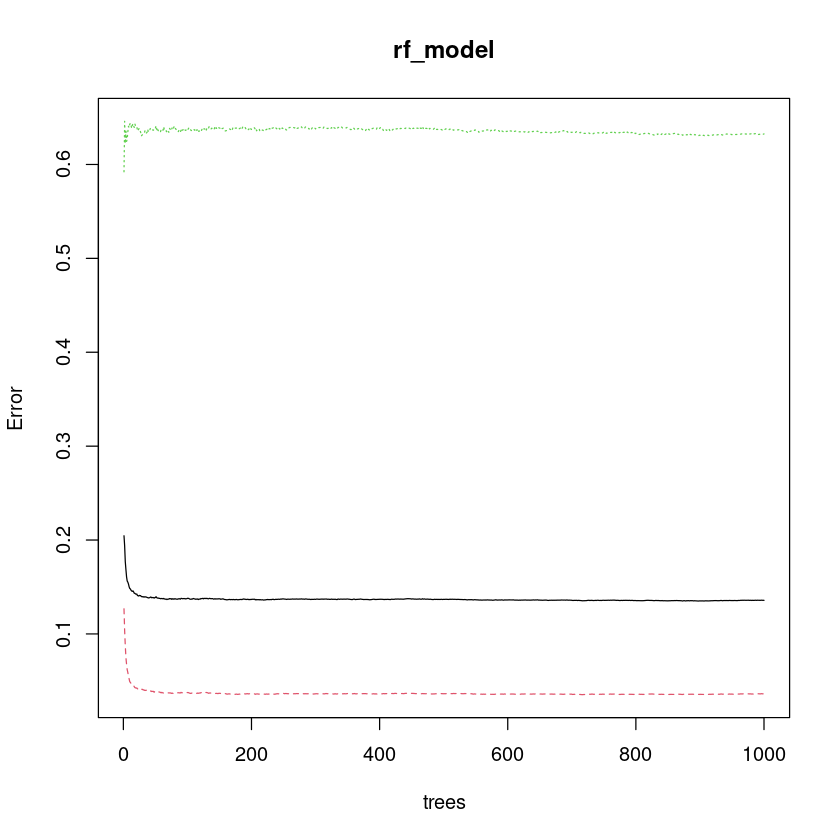

In [45]:
set.seed(11)
library(caret)

wetwt <- ifelse(train$class == "WET", 1.5, 1)

rf_model <- randomForest((class) ~ ., mtry = 10, 
                         sampsize = nrow(train[train$class == "WET",]),
                         replace = TRUE, #weights = wetwt, 
                         nodesize =1,
                         ntree = 1000, na.action = na.omit,
                         importance = TRUE, data = train)
plot(rf_model)

Confusion Matrix and Statistics

          Reference
Prediction   UPL   WET
       UPL 24681  2534
       WET   413  2503
                                          
               Accuracy : 0.9022          
                 95% CI : (0.8988, 0.9055)
    No Information Rate : 0.8328          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5777          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9835          
            Specificity : 0.4969          
         Pos Pred Value : 0.9069          
         Neg Pred Value : 0.8584          
             Prevalence : 0.8328          
         Detection Rate : 0.8191          
   Detection Prevalence : 0.9032          
      Balanced Accuracy : 0.7402          
                                          
       'Positive' Class : UPL             
                  

Confusion Matrix and Statistics

          Reference
Prediction   UPL   WET
       UPL 10395  1346
       WET   407   766
                                          
               Accuracy : 0.8643          
                 95% CI : (0.8582, 0.8701)
    No Information Rate : 0.8365          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3958          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9623          
            Specificity : 0.3627          
         Pos Pred Value : 0.8854          
         Neg Pred Value : 0.6530          
             Prevalence : 0.8365          
         Detection Rate : 0.8049          
   Detection Prevalence : 0.9092          
      Balanced Accuracy : 0.6625          
                                          
       'Positive' Class : UPL             
                  

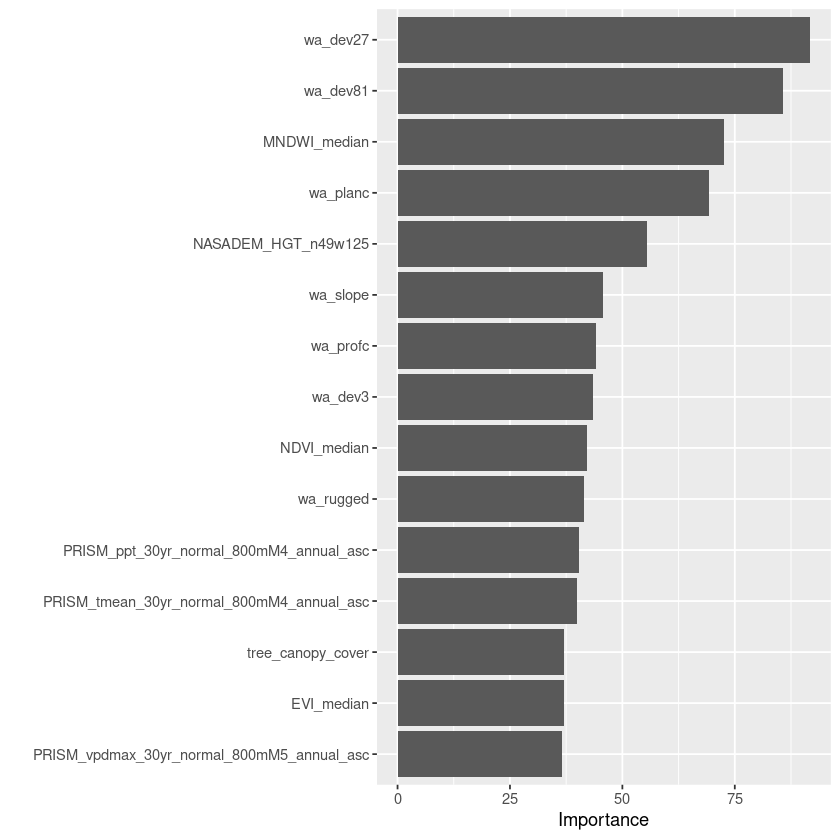

In [49]:
rf.test <- predict(rf_model, newdata = test, type = "response")
rf.train <- predict(rf_model, newdata = train)
caret::confusionMatrix(rf.train, train$class)
caret::confusionMatrix(rf.test, test$class)
vip::vip(rf_model, num_features = 15)

In [68]:
library(dplyr)
test_prob <- predict(rf_model, newdata = test, type = "prob") |> cbind(test) |>
        mutate(class_pred = case_when(WET > 0.50 ~ "WET",
                                     .default = "UPL")) |>
        mutate(wrong = case_when(class_pred != class ~ "WRONG",
                                .default = "RIGHT"))
test_prob

,UPL,WET,class,NASADEM_HGT_n49w125,wa_dev27,wa_dev3,wa_dev81,wa_dinfsca,wa_planc,wa_profc,⋯,PRISM_tmean_30yr_normal_800mM4_annual_asc,PRISM_vpdmax_30yr_normal_800mM5_annual_asc,tree_canopy_cover,NDVI_median,MNDWI_median,EVI_median,SAVI_median,NDYI_median,class_pred,wrong
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
15,0.513,0.487,WET,308.497345,-1.25672984,-0.29330215,-0.98443407,47.28609,127.260521,8.107146263,⋯,9.948825,10.367907,23,0.8715323,-0.6103517,0.6965138,0.6249533,0.3710781,UPL,WRONG
19,0.792,0.208,WET,486.467438,-0.82125336,-0.17574316,-1.10747087,89.29684,45.993130,23.402671814,⋯,8.858385,9.877605,74,0.8768173,-0.4547754,0.4229194,0.4171621,0.3218442,UPL,WRONG
20,0.840,0.160,WET,65.893051,0.12140884,0.41866663,-0.28623819,23.64304,-138.443375,-6.032558918,⋯,11.532589,11.053163,12,0.6165624,-0.4511389,0.4469494,0.4248155,0.2441844,UPL,WRONG
26,0.407,0.593,WET,41.574921,-0.57369471,0.13767934,-1.01735616,209.05208,11.930781,-9.478820801,⋯,11.506354,11.092112,32,0.8567594,-0.6005279,0.6046168,0.5513275,0.2667920,WET,RIGHT
33,0.865,0.135,WET,111.292000,-0.20944616,-0.10279150,-0.37518859,23.64304,-29.699738,21.625074387,⋯,11.169216,10.966806,56,0.8750895,-0.5410028,0.5984883,0.5526863,0.3233861,UPL,WRONG
37,0.690,0.310,WET,5.476902,0.44657683,0.32417133,-0.09635332,61.08588,-149.100189,-5.147170067,⋯,11.985991,10.776288,7,0.2149257,-0.2107056,0.1354749,0.1282389,0.1613324,UPL,WRONG
38,0.763,0.237,WET,329.586456,-0.77681720,0.04153407,-1.02111292,23.64304,-85.858879,18.320480347,⋯,9.997903,10.074986,63,0.8818315,-0.5588410,0.5252566,0.4987387,0.3645270,UPL,WRONG
46,0.697,0.303,WET,9.762291,0.58261579,0.53774625,0.30687565,94.41946,-315.449402,-4.204801559,⋯,11.786722,10.798767,14,0.4658156,-0.5566088,0.2998884,0.2992992,0.1687561,UPL,WRONG
49,0.521,0.479,WET,248.147858,-0.82974380,-0.51367980,-0.62561721,70.55918,259.256470,20.485858917,⋯,10.624806,11.053790,56,0.8850148,-0.6119425,0.7128213,0.6230931,0.2592312,UPL,WRONG


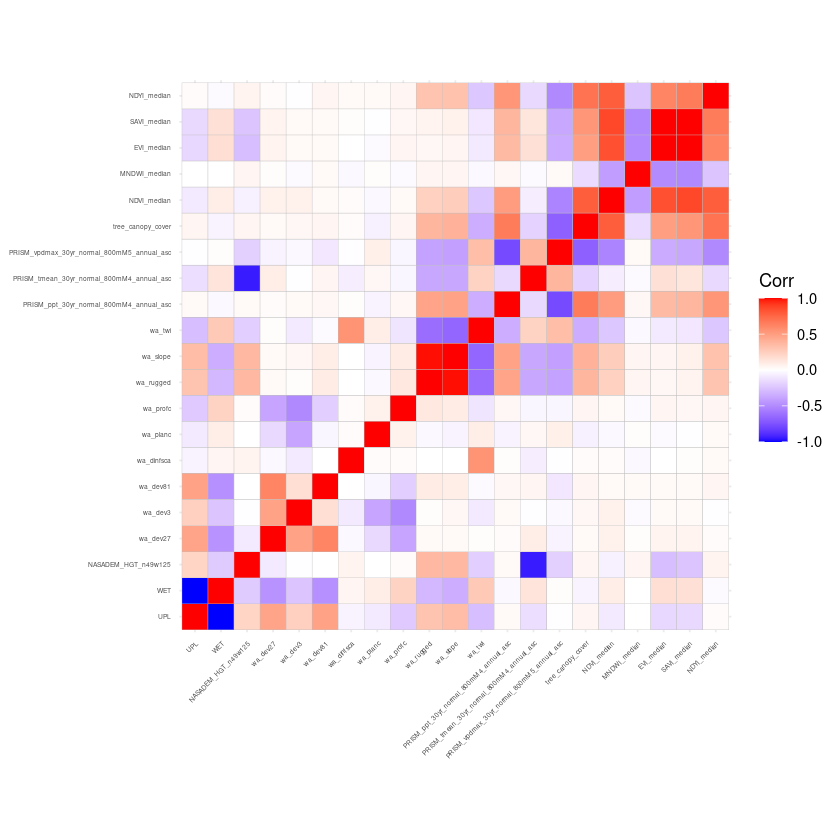

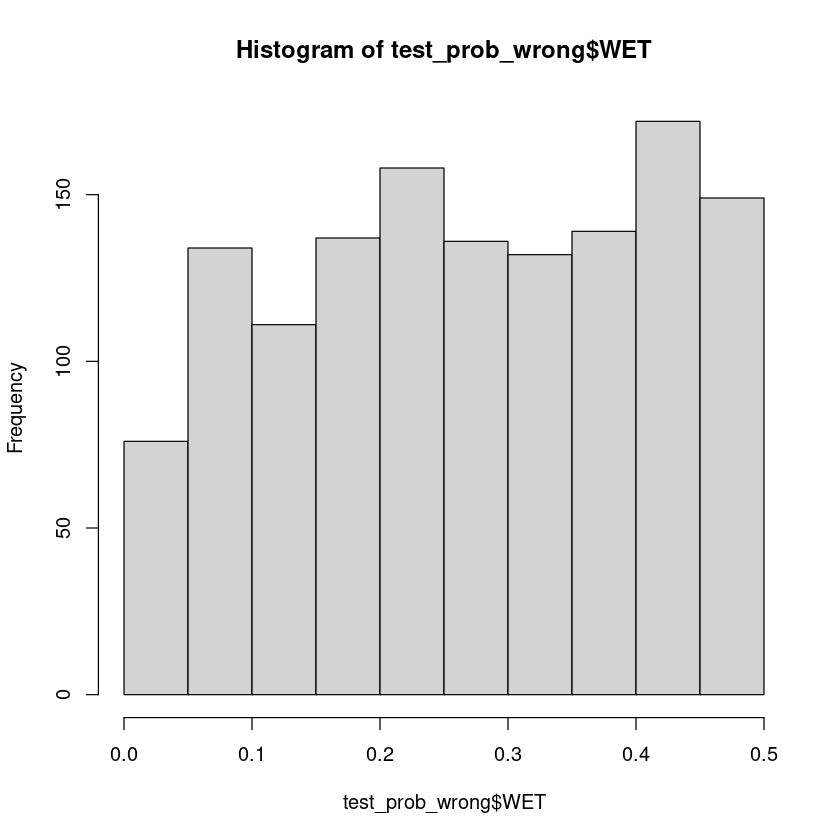

In [87]:
library(ggcorrplot)

test_prob_wrong <- test_prob |> filter(wrong == "WRONG" & WET < 0.50) |> select(where(is.numeric))

corrwrong <- round(cor(test_prob_wrong), 2)

ggcorrplot::ggcorrplot(corrwrong, lab = F, tl.cex = 4)

hist(test_prob_wrong$WET)

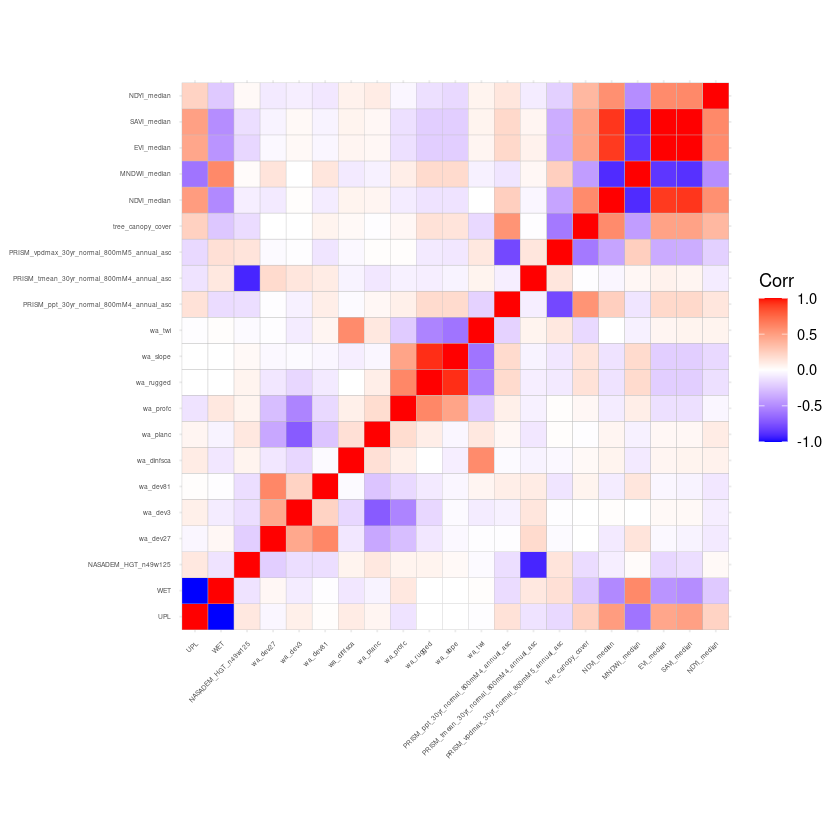

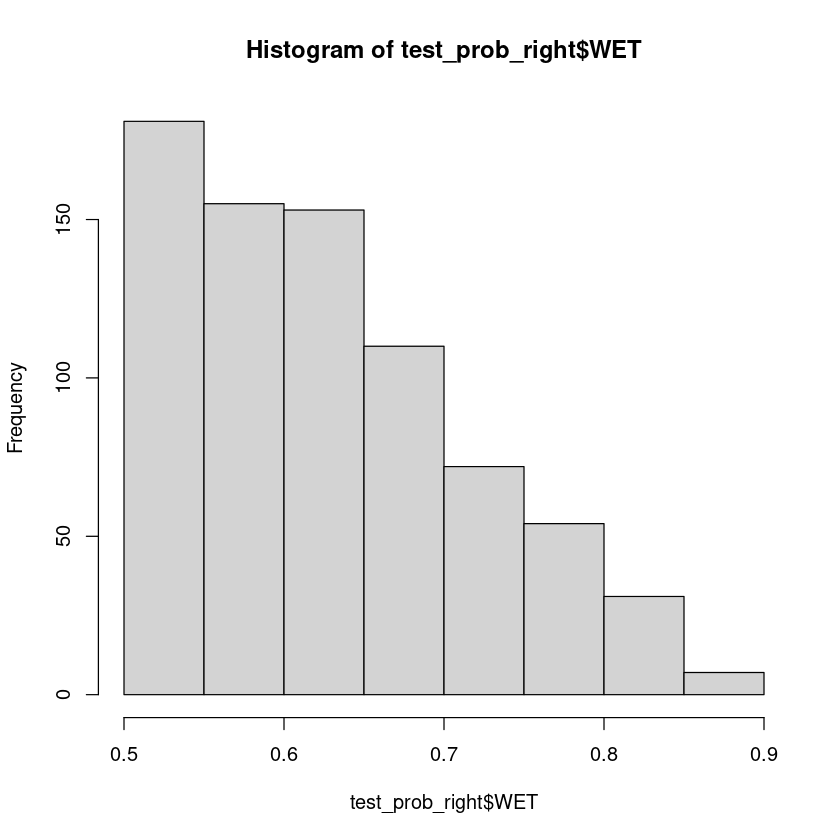

In [90]:
test_prob_right <- test_prob |> filter(wrong == "RIGHT" & WET > 0.50) |> select(where(is.numeric))

corrright <- round(cor(test_prob_right), 2)

ggcorrplot::ggcorrplot(corrright, lab = F, tl.cex = 4)

hist(test_prob_right$WET)

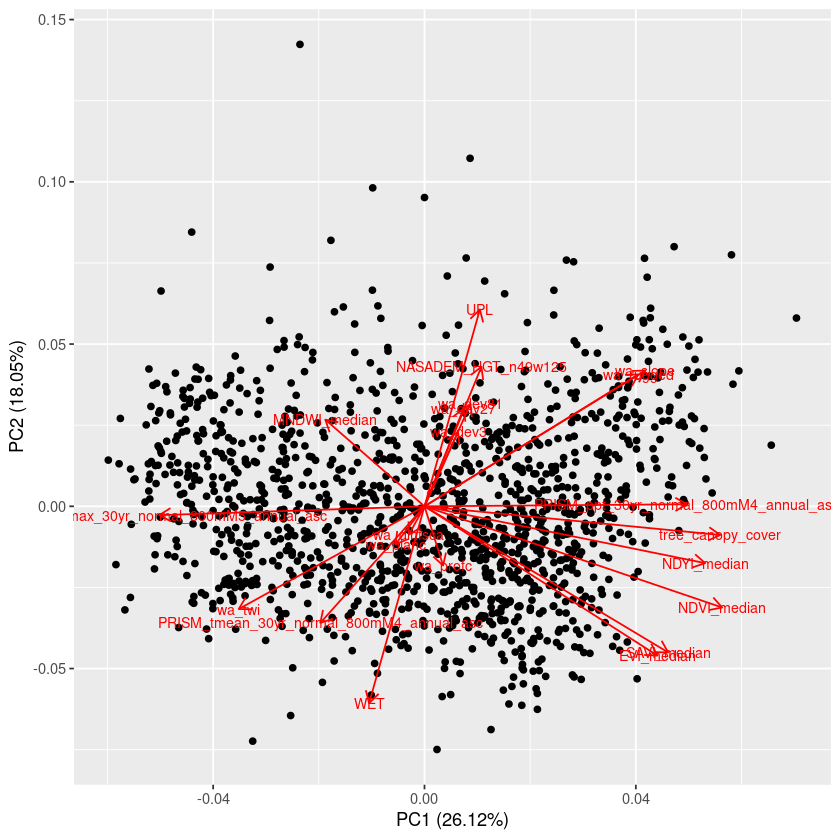

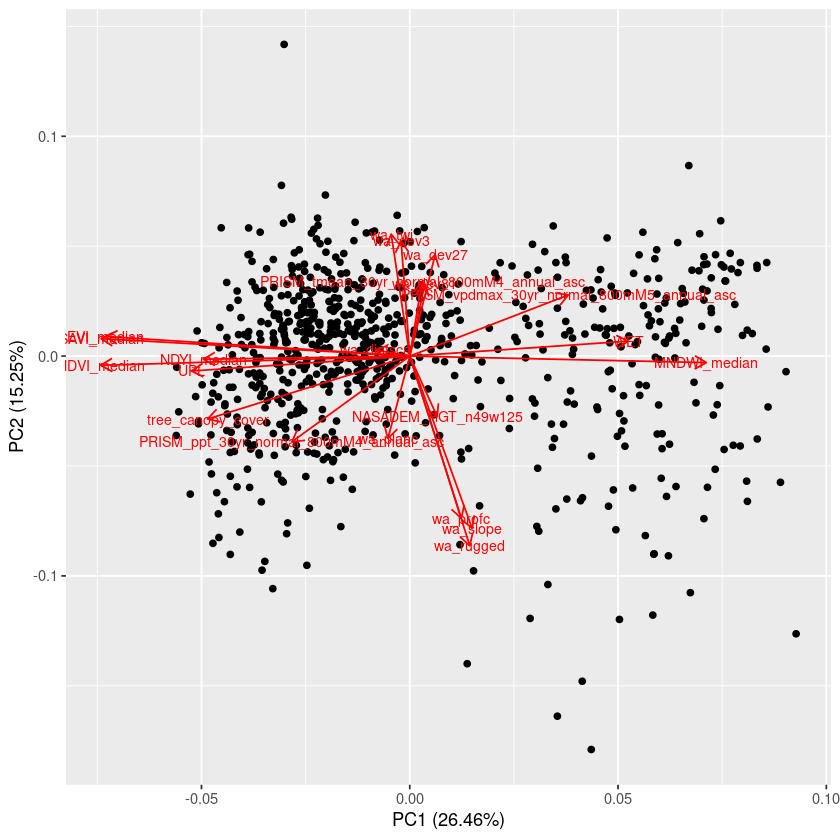

In [95]:
library(ggfortify)

wrong_pca <- prcomp(test_prob_wrong, scale = T)

autoplot(wrong_pca, loadings = T, 
         loadings.label = T, loadings.label.size = 3, labels.size = 1)

right_pca <- prcomp(test_prob_right, scale = T)

autoplot(right_pca, loadings = T, 
         loadings.label = T, loadings.label.size = 3, labels.size = 1)